In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
file_path = 'altered_loan_payments2.csv'
df = pd.read_csv(file_path)

In [4]:
total_amount_recovered = df['total_payment'].sum()
total_amount_funded = df['loan_amount'].sum()
recovery_percentage = (total_amount_recovered / total_amount_funded) * 100

print(f"Overall Recovery Percentage: {recovery_percentage:.2f}%")


Overall Recovery Percentage: 90.60%


## *Overall Recovery Percentage against Investor Funding:*

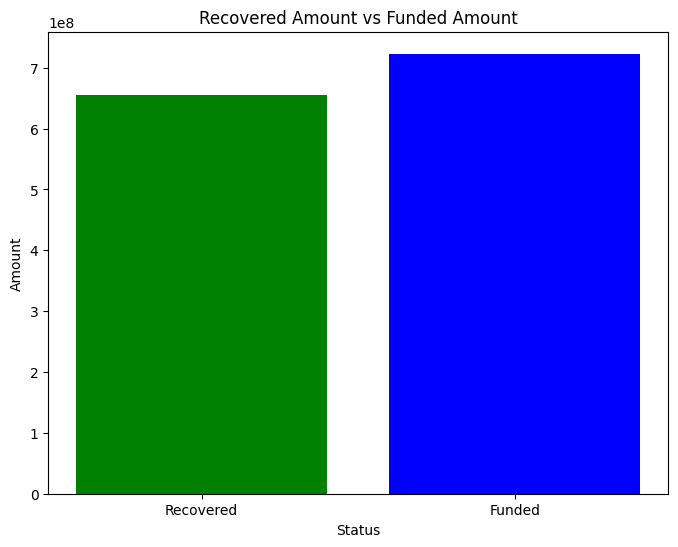

In [5]:
plt.figure(figsize=(8, 6))
plt.bar(['Recovered', 'Funded'], [total_amount_recovered, total_amount_funded], color=['green', 'blue'])
plt.xlabel('Status')
plt.ylabel('Amount')
plt.title('Recovered Amount vs Funded Amount')
plt.show()

## *Calculating Loss:*

In [6]:
charged_off_loans = df[df['loan_status'] == 'Charged Off'].shape[0]

# Calculate the total amount paid towards charged off loans
total_amount_paid = df[df['loan_status'] == 'Charged Off']['total_payment'].sum()

# Calculate the total number of all loans
total_loans = df.shape[0]

# Calculate the percentage of charged off loans
percentage_charged_off = (charged_off_loans / total_loans) * 100

print(f"Percentage of Charged Off Loans: {percentage_charged_off:.2f}%")
print(f"Total Amount Paid for Charged Off Loans: ${total_amount_paid:.2f}")

Percentage of Charged Off Loans: 10.27%
Total Amount Paid for Charged Off Loans: $37400589.04


## *Calculating Projected Loss:*

In [10]:
# Casting 'term' column to integer data type
df['term'] = df['term'].astype(int)
#df.to_csv('altered_loan_payments2.csv', index=False)

C:\Users\maahi\AppData\Local\Temp\ipykernel_30596\1763192848.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_loans['projected_loss'] = incomplete_loans['loan_amount'] - incomplete_loans['total_payment']
C:\Users\maahi\AppData\Local\Temp\ipykernel_30596\1763192848.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_loans['remaining_term'] = (pd.to_datetime(incomplete_loans['last_payment_date']) - pd.to_datetime(datetime.now())).dt.days / 30


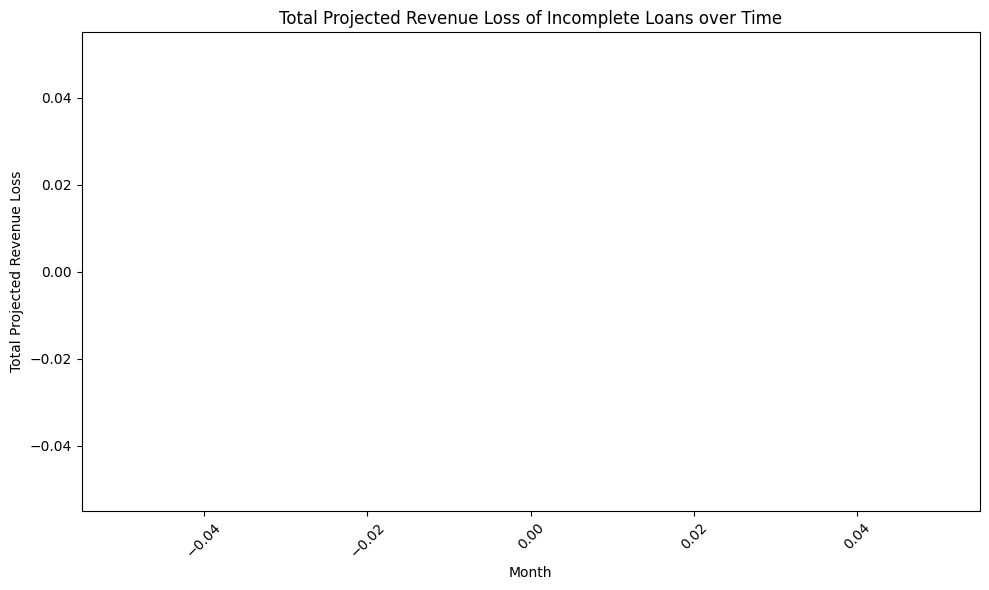

In [16]:
# Filter the data for loans marked as Charged Off or incomplete loans
incomplete_loans = df[df['loan_status'].isin(['Charged Off', 'Incomplete'])]

# Calculate projected loss of the incomplete loans
incomplete_loans['projected_loss'] = incomplete_loans['loan_amount'] - incomplete_loans['total_payment']

# Calculate the remaining term in months for the incomplete loans
incomplete_loans['remaining_term'] = (pd.to_datetime(incomplete_loans['last_payment_date']) - pd.to_datetime(datetime.now())).dt.days / 30

# Filter loans with remaining term less than 0 (past due)
incomplete_loans = incomplete_loans[incomplete_loans['remaining_term'] > 0]
incomplete_loans['Month'] = pd.to_datetime(incomplete_loans['last_payment_date']).dt.to_period('M')

# Calculate the loss in revenue these loans would have generated if they had finished their term
incomplete_loans['projected_revenue_loss'] = incomplete_loans['remaining_term'] * incomplete_loans['int_rate'] * incomplete_loans['loan_amount'] / 100

# Group by months or time intervals and sum the projected revenue loss
grouped_loss = incomplete_loans.groupby('Month').agg({'projected_revenue_loss': 'sum'}).reset_index()

# Visualize the total loss projected over the remaining term of these loans
plt.figure(figsize=(10, 6))
plt.bar(grouped_loss['Month'], grouped_loss['projected_revenue_loss'], color='red')
plt.xlabel('Month')
plt.ylabel('Total Projected Revenue Loss')
plt.title('Total Projected Revenue Loss of Incomplete Loans over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# charged_off_loans = df[df['loan_status'] == 'Charged Off']

# # Calculate the remaining balance for each Charged Off loan
# charged_off_loans['remaining_balance'] = charged_off_loans['loan_amount'] - charged_off_loans['total_payment']

# # Handle NaN values in 'loan_amount' or 'total_amount_paid' columns
# charged_off_loans = charged_off_loans.dropna(subset=['loan_amount', 'total_payment'])

# # Calculate the projected loss of the Charged Off loans
# projected_loss = charged_off_loans['remaining_balance'].sum()

# # Visualize the loss projected over the remaining term of these loans
# plt.figure(figsize=(8, 6))
# for index, row in charged_off_loans.iterrows():
#     if pd.notnull(row['loan_amount']) and pd.notnull(row['total_payment']):
#         remaining_term = range(row['term'] - round(row['term'] * row['total_payment'] / row['loan_amount']), row['term'])
#         remaining_balances = [row['remaining_balance'] * (1 - (p / row['term'])) for p in remaining_term]
#         plt.plot(remaining_term, remaining_balances, label=f'Loan {index}')

# plt.xlabel('Remaining Term (Months)')
# plt.ylabel('Remaining Balance')
# plt.title('Projected Loss Over Remaining Loan Term')
# plt.legend()
# plt.show()

# print(f"Projected Loss of Charged Off Loans: ${projected_loss:.2f}")

## *Possible Loss:*

In [17]:
# Identify customers currently behind on payments
late_customers = df[(df['loan_status'] != 'Charged Off') & (df['total_payment'] < df['loan_amount'])]

# Calculate the percentage of late customers as a percentage of all loans
percentage_late_customers = (late_customers.shape[0] / df.shape[0]) * 100

# Calculate the total number of customers in this bracket
total_late_customers = late_customers.shape[0]

# Calculate the loss the company would incur if the status of late customers changed to Charged Off
loss_if_charged_off = late_customers['loan_amount'].sum() - late_customers['total_payment'].sum()

# Calculate the projected loss if these late-paying customers were to finish the full loan term
late_customers['remaining_balance'] = late_customers['loan_amount'] - late_customers['total_payment']
projected_loss_full_term = late_customers['remaining_balance'].sum()

# Calculate the total expected revenue
total_expected_revenue = df['loan_amount'].sum()

# Calculate the percentage of total expected revenue represented by late-paying and already defaulted customers
total_loss_customers = df[df['loan_status'] == 'Charged Off']
total_loss_customers_amount = total_loss_customers['loan_amount'].sum() - total_loss_customers['total_payment'].sum()
percentage_total_loss_customers = ((loss_if_charged_off + total_loss_customers_amount) / total_expected_revenue) * 100

print(f"Percentage of customers currently behind on payments: {percentage_late_customers:.2f}%")
print(f"Total number of customers currently behind on payments: {total_late_customers}")
print(f"Loss if late customers' status changed to Charged Off: ${loss_if_charged_off:.2f}")
print(f"Projected loss of late customers if they finish full term: ${projected_loss_full_term:.2f}")
print(f"Percentage of total expected revenue represented by late-paying and already defaulted customers: {percentage_total_loss_customers:.2f}%")

Percentage of customers currently behind on payments: 36.00%
Total number of customers currently behind on payments: 19525
Loss if late customers' status changed to Charged Off: $88388250.01
Projected loss of late customers if they finish full term: $88388250.01
Percentage of total expected revenue represented by late-paying and already defaulted customers: 17.61%


C:\Users\maahi\AppData\Local\Temp\ipykernel_30596\3320206737.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_customers['remaining_balance'] = late_customers['loan_amount'] - late_customers['total_payment']


## *Indicators of Loss:*

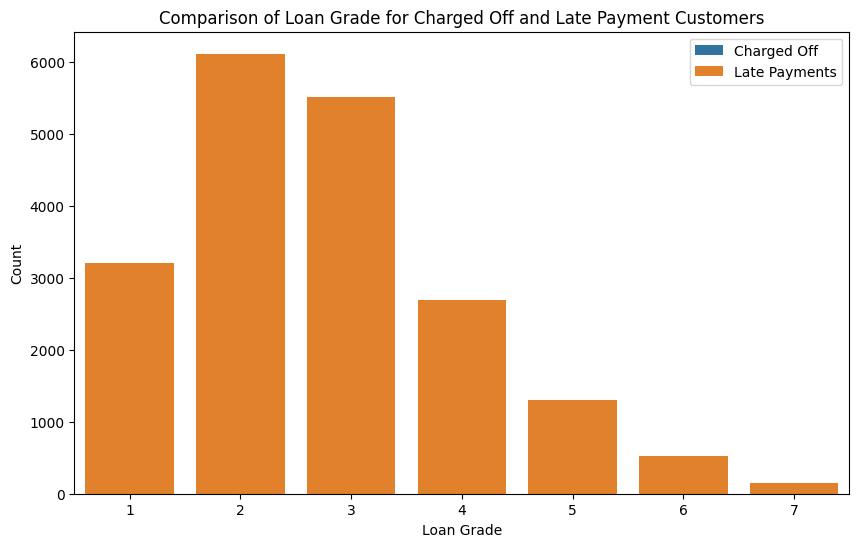

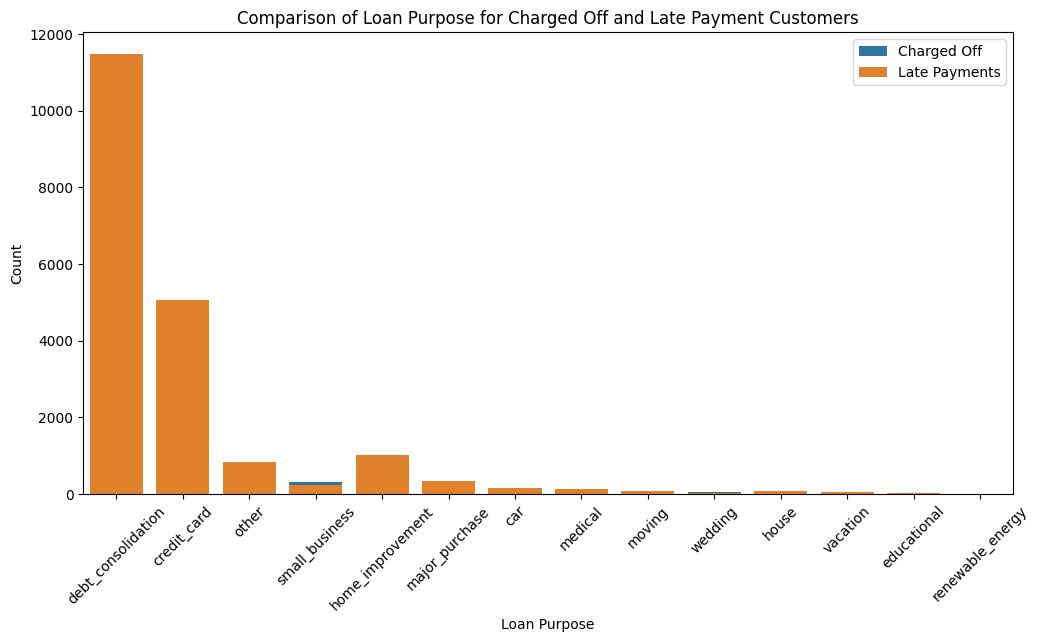

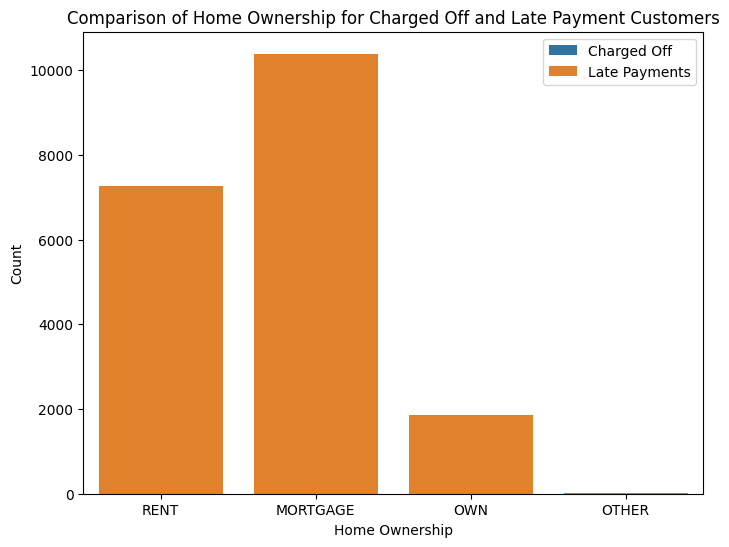

In [18]:
# Create a subset of users who are Charged Off and users currently behind on payments
charged_off_customers = df[df['loan_status'] == 'Charged Off']
late_customers = df[(df['loan_status'] != 'Charged Off') & (df['total_payment'] < df['loan_amount'])]

# Compare loan grade against customers who have stopped paying
plt.figure(figsize=(10, 6))
sns.countplot(x='grade', data=charged_off_customers, order=sorted(charged_off_customers['grade'].unique()), label='Charged Off')
sns.countplot(x='grade', data=late_customers, order=sorted(charged_off_customers['grade'].unique()), label='Late Payments')
plt.title('Comparison of Loan Grade for Charged Off and Late Payment Customers')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.legend()
plt.show()

# Compare loan purpose against customers who have stopped paying
plt.figure(figsize=(12, 6))
sns.countplot(x='purpose', data=charged_off_customers, order=charged_off_customers['purpose'].value_counts().index, label='Charged Off')
sns.countplot(x='purpose', data=late_customers, order=charged_off_customers['purpose'].value_counts().index, label='Late Payments')
plt.title('Comparison of Loan Purpose for Charged Off and Late Payment Customers')
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Compare home ownership against customers who have stopped paying
plt.figure(figsize=(8, 6))
sns.countplot(x='home_ownership', data=charged_off_customers, order=charged_off_customers['home_ownership'].value_counts().index, label='Charged Off')
sns.countplot(x='home_ownership', data=late_customers, order=charged_off_customers['home_ownership'].value_counts().index, label='Late Payments')
plt.title('Comparison of Home Ownership for Charged Off and Late Payment Customers')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.legend()
plt.show()